### Imports

In [1]:
import os, glob, platform, random, copy, math, warnings
from collections import defaultdict
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.utils import shuffle
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix
)

### Config

In [2]:
DATA_ROOT   = "E:/TFM/Dataset_una_clase"   # {train,val,test}/{negative,positive}
IMAGE_SIZE  = 224
SEED        = 42
NUM_WORKERS = 0 if platform.system().lower().startswith("win") else 4
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Entrenamiento métrico
LOSS_TYPE   = "triplet"   # "triplet" | "contrastive"
MARGIN      = 0.5         # margen para triplet/contrastive
EMB_DIM     = 512
LR          = 1e-4
WEIGHT_DECAY= 1e-4
EPOCHS      = 80
PATIENCE    = 8
OUT_DIR     = "E:/TFM/modelos/outputs_siamese_triplet"

# PK batching (para que haya positivos/negativos en cada batch)
P_CLASSES   = 2           # en binario -> 2
K_SAMPLES   = 16          # por clase (batch = P*K); ajústalo a tu VRAM
BATCH_SIZE  = P_CLASSES * K_SAMPLES

# Clasificación downstream
LEARN_TAU   = True        # aprende temperatura en VAL (recomendado)
GRID_TAUS   = np.geomspace(0.25, 4.0, 13)  # si LEARN_TAU=False

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()


Device: cuda


### Transforms


In [3]:
def _resize(img_size: int):
    return A.Resize(height=img_size, width=img_size)

def _random_resized_crop(img_size: int):
    try:
        return A.RandomResizedCrop(size=(img_size, img_size), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)
    except TypeError:
        return A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)

train_tf = A.Compose([
    _random_resized_crop(IMAGE_SIZE),
    A.Affine(translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
             scale=(0.9, 1.1), rotate=(-7, 7),
             interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=0.9),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.RandomBrightnessContrast(0.10, 0.10, p=0.7),
    A.GaussianBlur(blur_limit=(3, 3), p=0.2),
    A.Normalize(mean=[0.5]*3, std=[0.25]*3),
    ToTensorV2(),
])

eval_tf = A.Compose([
    _resize(IMAGE_SIZE),
    A.Normalize(mean=[0.5]*3, std=[0.25]*3),
    ToTensorV2(),
])

### Dataset

In [4]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_split_dir, transform=None):
        self.root = root_split_dir
        self.transform = transform
        self.class_to_idx = {"negative": 0, "positive": 1}
        self.samples = []
        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")
        for cls in ["negative", "positive"]:
            for ext in exts:
                for f in glob.glob(os.path.join(self.root, cls, ext)):
                    self.samples.append((f, self.class_to_idx[cls]))
        # filtrar ilegibles
        valid, skipped = [], []
        for path, label in self.samples:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None or img.size == 0:
                skipped.append(path)
            else:
                valid.append((path, label))
        if skipped:
            print(f"[WARN] {len(skipped)} ilegibles en {self.root}, se omiten.")
        self.samples = shuffle(valid, random_state=SEED)
        if len(self.samples) == 0:
            raise RuntimeError(f"No hay imágenes en {self.root}")
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform: img = self.transform(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)

def make_datasets():
    train_ds = ChestXrayDataset(os.path.join(DATA_ROOT, "train"), transform=train_tf)
    val_ds   = ChestXrayDataset(os.path.join(DATA_ROOT, "val"),   transform=eval_tf)
    test_ds  = ChestXrayDataset(os.path.join(DATA_ROOT, "test"),  transform=eval_tf)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_datasets()
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Train: 278 | Val: 93 | Test: 93


### Batch sampler

In [5]:
def index_by_class(ds):
    idxs = defaultdict(list)
    for i, (_, y) in enumerate(ds.samples):
        idxs[y].append(i)
    return idxs

class PKBatchSampler(Sampler):
    def __init__(self, class_to_indices, P, K, n_batches):
        self.class_to_indices = class_to_indices
        self.P = P; self.K = K
        self.n_batches = n_batches
        self.classes = list(class_to_indices.keys())
    def __len__(self):
        return self.n_batches
    def __iter__(self):
        for _ in range(self.n_batches):
            chosen = np.random.choice(self.classes, size=self.P, replace=False if len(self.classes)>=self.P else True)
            batch_idx = []
            for c in chosen:
                pool = self.class_to_indices[c]
                idxs = np.random.choice(pool, size=self.K, replace=len(pool)<self.K)
                batch_idx.extend(idxs.tolist())
            yield batch_idx

train_index = index_by_class(train_ds)
# n_batches por epoch ~ |train| / (P*K)
N_BATCHES = max(1, len(train_ds) // (P_CLASSES*K_SAMPLES))

train_loader = DataLoader(
    train_ds, batch_sampler=PKBatchSampler(train_index, P_CLASSES, K_SAMPLES, N_BATCHES),
    num_workers=NUM_WORKERS, pin_memory=False
)
val_loader   = DataLoader(val_ds,  batch_size=64, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)


### Encoder

In [6]:
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True, proj_dim=EMB_DIM):
        super().__init__()
        try:
            weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
            base = models.resnet50(weights=weights)
        except Exception:
            base = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(base.children())[:-1]) # [B,2048,1,1]
        self.proj = nn.Sequential(nn.Flatten(), nn.Linear(2048, proj_dim))
    def forward(self, x):
        z = self.backbone(x)           # [B,2048,1,1]
        e = self.proj(z)               # [B,EMB]
        e = nn.functional.normalize(e, dim=1)
        return e

encoder = ResNetEncoder(pretrained=True).to(device)

### Triplet

In [7]:
def pairwise_dist(emb):
    # emb: [B,D] L2-normalized -> cos dist y euclidian relacionadas
    # euclídea: d^2 = 2 - 2*cos
    sim = emb @ emb.t()                        # [B,B]
    sim = sim.clamp(-1,1)
    d2 = 2 - 2*sim
    d  = torch.sqrt(torch.clamp(d2, min=1e-12))
    return d, sim

def mine_triplets_semihard(emb, y, margin=0.5):
    with torch.no_grad():
        d, _ = pairwise_dist(emb)          # [B,B]
        y = y.view(-1,1)
        mask_pos = (y == y.t()) & (~torch.eye(len(y), dtype=torch.bool, device=y.device))
        mask_neg = (y != y.t())

        a_idx, p_idx, n_idx = [], [], []
        for a in range(d.size(0)):
            d_ap = d[a][mask_pos[a]]       # dist a positivos
            pos_idx = torch.nonzero(mask_pos[a], as_tuple=False).view(-1)
            if d_ap.numel()==0: 
                continue
            # elige el positivo "difícil razonable" (p. ej., el más lejano)
            p_sel = torch.argmax(d_ap).item()
            p = pos_idx[p_sel].item()
            dap = d[a, p].item()

            # semi-hard negatives
            mask_n = mask_neg[a] & (d[a] > dap) & (d[a] < dap + margin)
            neg_candidates = torch.nonzero(mask_n, as_tuple=False).view(-1)
            if neg_candidates.numel() == 0:
                # fallback: hard negatives (d(a,n) <= d(a,p))
                mask_hard = mask_neg[a] & (d[a] <= dap)
                neg_candidates = torch.nonzero(mask_hard, as_tuple=False).view(-1)
                if neg_candidates.numel() == 0:
                    continue
            # elige el negativo más cercano dentro de candidatos
            d_an = d[a][neg_candidates]
            n = neg_candidates[torch.argmin(d_an)].item()
            a_idx.append(a); p_idx.append(p); n_idx.append(n)

    return torch.tensor(a_idx, device=emb.device, dtype=torch.long), \
           torch.tensor(p_idx, device=emb.device, dtype=torch.long), \
           torch.tensor(n_idx, device=emb.device, dtype=torch.long)

def mine_pairs_for_contrastive(emb, y, margin=0.5, max_pairs_per_anchor=4):
    with torch.no_grad():
        d, _ = pairwise_dist(emb)
        y = y.view(-1,1)
        mask_pos = (y == y.t()) & (~torch.eye(len(y), dtype=torch.bool, device=y.device))
        mask_neg = (y != y.t())
        pos_pairs_i, pos_pairs_j = torch.nonzero(mask_pos, as_tuple=True)
        # reducir positivos: máximo 'max_pairs_per_anchor' por ancla
        keep = []
        count = torch.zeros(d.size(0), dtype=torch.long, device=d.device)
        for i,j in zip(pos_pairs_i.tolist(), pos_pairs_j.tolist()):
            if count[i] < max_pairs_per_anchor:
                keep.append((i,j)); count[i]+=1
        pos_pairs = keep

        # negativos semi-hard: d < margin
        neg_pairs = []
        for i in range(d.size(0)):
            cand = torch.nonzero(mask_neg[i] & (d[i] < margin), as_tuple=False).view(-1)
            if cand.numel() == 0: 
                continue
            # coge unos pocos más cercanos
            d_i = d[i][cand]
            order = torch.argsort(d_i)[:max_pairs_per_anchor]
            for j in cand[order].tolist():
                neg_pairs.append((i, j))
    # construir tensores
    if len(pos_pairs)==0 and len(neg_pairs)==0:
        return None, None
    pairs = pos_pairs + neg_pairs
    ij = torch.tensor(pairs, device=emb.device, dtype=torch.long)
    m  = torch.cat([torch.ones(len(pos_pairs), device=emb.device),
                    torch.zeros(len(neg_pairs), device=emb.device)], dim=0)
    return ij, m

### Loss

In [8]:
def triplet_loss_from_indices(emb, a_idx, p_idx, n_idx, margin=0.5):
    if a_idx.numel()==0: 
        return None
    d, _ = pairwise_dist(emb)
    dap = d[a_idx, p_idx]
    dan = d[a_idx, n_idx]
    loss = torch.clamp(dap - dan + margin, min=0).mean()
    return loss

def contrastive_loss_pairs(emb, ij, m, margin=0.5):
    # m=1 -> positivo: L = d^2 ; m=0 -> negativo: L = max(0,marg - d)^2
    if ij is None: 
        return None
    xi = emb[ij[:,0]]; xj = emb[ij[:,1]]
    d = torch.norm(xi - xj, dim=1)
    loss_pos = (m * (d**2))
    loss_neg = ((1-m) * torch.clamp(margin - d, min=0)**2)
    return (loss_pos + loss_neg).mean()

### Entrenamiento

In [9]:
def train_metric(encoder, train_loader, val_loader, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, margin=MARGIN):
    os.makedirs(OUT_DIR, exist_ok=True)
    enc = encoder
    opt = optim.AdamW(enc.parameters(), lr=lr, weight_decay=wd)
    sch = CosineAnnealingLR(opt, T_max=epochs)
    best_state, best_val = None, -1
    no_imp = 0

    for ep in range(epochs):
        enc.train()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            emb = enc(xb)
            if LOSS_TYPE == "triplet":
                a, p, n = mine_triplets_semihard(emb, yb, margin=margin)
                loss = triplet_loss_from_indices(emb, a, p, n, margin=margin)
                if loss is None: 
                    continue
            else:
                ij, m = mine_pairs_for_contrastive(emb, yb, margin=margin)
                loss = contrastive_loss_pairs(emb, ij, m, margin=margin)
                if loss is None:
                    continue
            loss.backward(); opt.step()
            losses.append(loss.item())
        sch.step()

        # --- validación simple: kNN-1 sobre VAL para criterio (aprox)
        enc.eval()
        with torch.no_grad():
            # embeddings train (para referencia)
            tr_embs, tr_lbls = [], []
            for x,y in train_loader:
                x = x.to(device)
                e = enc(x)
                tr_embs.append(e.cpu()); tr_lbls.append(y)
            TR = torch.cat(tr_embs,0); YTR = torch.cat(tr_lbls,0).numpy()

            # embeddings val
            val_embs, val_lbls = [], []
            for x,y in val_loader:
                x = x.to(device)
                e = enc(x)
                val_embs.append(e.cpu()); val_lbls.append(y)
            EV = torch.cat(val_embs,0); YV = torch.cat(val_lbls,0).numpy()

            # 1-NN por coseno
            TRn = nn.functional.normalize(TR, dim=1)
            EVn = nn.functional.normalize(EV, dim=1)
            sims = EVn @ TRn.t()                               # [Nv, Nt]
            idx = torch.argmax(sims, dim=1)
            preds = YTR[idx.numpy()]
            acc_val = (preds == YV).mean()

        val_score = acc_val
        print(f"[E{ep+1}/{epochs}] loss={np.mean(losses):.4f} | val_1nn_acc={acc_val:.3f}")

        if val_score > best_val:
            best_val = val_score; no_imp = 0
            best_state = copy.deepcopy(enc.state_dict())
            torch.save(best_state, os.path.join(OUT_DIR, "best_metric.pt"))
        else:
            no_imp += 1
            if no_imp >= PATIENCE:
                print("Early stopping.")
                break

    if best_state is not None:
        enc.load_state_dict(best_state)
    return enc

encoder = train_metric(encoder, train_loader, val_loader)


[E1/80] loss=0.5808 | val_1nn_acc=0.462
[E2/80] loss=0.5754 | val_1nn_acc=0.538
[E3/80] loss=0.5647 | val_1nn_acc=0.559
[E4/80] loss=0.5607 | val_1nn_acc=0.527
[E5/80] loss=0.5535 | val_1nn_acc=0.570
[E6/80] loss=0.5549 | val_1nn_acc=0.602
[E7/80] loss=0.5337 | val_1nn_acc=0.516
[E8/80] loss=0.5352 | val_1nn_acc=0.602
[E9/80] loss=0.5369 | val_1nn_acc=0.548
[E10/80] loss=0.5393 | val_1nn_acc=0.634
[E11/80] loss=0.5222 | val_1nn_acc=0.688
[E12/80] loss=0.5225 | val_1nn_acc=0.634
[E13/80] loss=0.5076 | val_1nn_acc=0.677
[E14/80] loss=0.5348 | val_1nn_acc=0.624
[E15/80] loss=0.4951 | val_1nn_acc=0.720
[E16/80] loss=0.4744 | val_1nn_acc=0.742
[E17/80] loss=0.4678 | val_1nn_acc=0.753
[E18/80] loss=0.4235 | val_1nn_acc=0.753
[E19/80] loss=0.3992 | val_1nn_acc=0.753
[E20/80] loss=0.4809 | val_1nn_acc=0.731
[E21/80] loss=0.4417 | val_1nn_acc=0.753
[E22/80] loss=0.4466 | val_1nn_acc=0.699
[E23/80] loss=0.4081 | val_1nn_acc=0.785
[E24/80] loss=0.3602 | val_1nn_acc=0.753
[E25/80] loss=0.2891 | va

### Evaluación

In [10]:
@torch.no_grad()
def embeddings_of_dataset(ds, batch_size=64):
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    embs, ys = [], []
    for x,y in loader:
        x = x.to(device)
        e = encoder(x)
        e = nn.functional.normalize(e, dim=1)
        embs.append(e.cpu()); ys.append(y)
    return torch.cat(embs,0), torch.cat(ys,0)

def build_prototypes_from_all(train_ds):
    E, Y = embeddings_of_dataset(train_ds)
    Y = Y.numpy()
    prot_neg = E[torch.tensor(Y)==0].mean(dim=0, keepdim=True)
    prot_pos = E[torch.tensor(Y)==1].mean(dim=0, keepdim=True)
    protos = torch.cat([prot_neg, prot_pos], dim=0)
    protos = nn.functional.normalize(protos, dim=1)
    return protos

@torch.no_grad()
def probs_from_protos(ds, protos, tau=1.0, batch_size=64):
    protos_dev = protos.to(device)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    probs, ys = [], []
    for x,y in loader:
        x = x.to(device)
        e = encoder(x)
        e = nn.functional.normalize(e, dim=1)
        logits = (e @ protos_dev.T) / tau        # [B,2]
        p = torch.softmax(logits, dim=1)[:,1]
        probs.append(p.cpu().numpy()); ys.append(y.numpy())
    return np.concatenate(probs,0), np.concatenate(ys,0)

class TemperatureScaler(nn.Module):
    def __init__(self, init_tau=1.0): 
        super().__init__()
        self.log_tau = nn.Parameter(torch.tensor([math.log(init_tau)], dtype=torch.float32))
    def forward(self, logits): 
        return logits / torch.exp(self.log_tau)

def collect_logits_targets(ds, protos, batch_size=64):
    protos_dev = protos.to(device)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    logits_list, y_list = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            e = encoder(x); e = nn.functional.normalize(e, dim=1)
            logits = e @ protos_dev.T       # [B,2]
            logits_list.append(logits); y_list.append(y.to(device))
    return torch.cat(logits_list,0), torch.cat(y_list,0)

def fit_temperature_on_val(ds, protos, max_iter=200, lr=0.05):
    logits, y = collect_logits_targets(ds, protos)
    scaler = TemperatureScaler(init_tau=1.0).to(device)
    ce = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS(scaler.parameters(), lr=lr, max_iter=max_iter)
    def closure():
        opt.zero_grad()
        loss = ce(scaler(logits), y)
        loss.backward()
        return loss
    opt.step(closure)
    with torch.no_grad():
        tau = float(torch.exp(scaler.log_tau).item())
    return tau

def find_threshold_for_spec(probs, targets, target_spec=0.95):
    ts = np.linspace(0,1,1001); best = {"thr":0.5,"sens":0.0,"spec":0.0}
    for t in ts:
        preds = (probs>=t).astype(np.int64)
        tn = np.sum((preds==0)&(targets==0)); fp = np.sum((preds==1)&(targets==0))
        tp = np.sum((preds==1)&(targets==1)); fn = np.sum((preds==0)&(targets==1))
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0; sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if spec>=target_spec and sens>best["sens"]:
            best={"thr":float(t),"sens":float(sens),"spec":float(spec)}
    return best

def find_threshold_max_f1(probs, targets):
    ts = np.linspace(0,1,1001); best={"thr":0.5,"f1":0.0}
    for t in ts:
        preds=(probs>=t).astype(np.int64)
        tp=np.sum((preds==1)&(targets==1)); fp=np.sum((preds==1)&(targets==0)); fn=np.sum((preds==0)&(targets==1))
        f1=(2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
        if f1>best["f1"]: best={"thr":float(t),"f1":float(f1)}
    return best

def eval_with_thr(probs, targets, thr):
    preds=(probs>=thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    acc=(tp+tn)/(tp+tn+fp+fn); spec=tn/(tn+fp) if (tn+fp)>0 else 0.0
    sens=tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1=(2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
    return {"acc":acc,"sens":sens,"spec":spec,"f1":f1,"tp":tp,"fp":fp,"tn":tn,"fn":fn}

# Prototipos de TODO el TRAIN
protos_train = build_prototypes_from_all(train_ds)

In [11]:
if LEARN_TAU:
    tau_val = fit_temperature_on_val(val_ds, protos_train)
    print(f"[Temperature scaling] τ aprendido en VAL: {tau_val:.3f}")
else:
    scores=[]
    for tau in GRID_TAUS:
        pv, yv = probs_from_protos(val_ds, protos_train, tau)
        try: scores.append((tau, roc_auc_score(yv, pv)))
        except: scores.append((tau, 0.0))
    tau_val = max(scores, key=lambda x: x[1])[0]
    print(f"[Grid τ] Mejor τ en VAL: {tau_val:.3f}")

pv, yv = probs_from_protos(val_ds, protos_train, tau=tau_val)
opt_f1   = find_threshold_max_f1(pv, yv)
opt_spec = find_threshold_for_spec(pv, yv, 0.95)
print("VAL (max F1):", opt_f1)
print("VAL (~95% spec):", opt_spec)

[Temperature scaling] τ aprendido en VAL: 0.782
VAL (max F1): {'thr': 0.339, 'f1': 0.8761904761904762}
VAL (~95% spec): {'thr': 0.898, 'sens': 0.1276595744680851, 'spec': 0.9565217391304348}


In [12]:
pt, yt = probs_from_protos(test_ds, protos_train, tau=tau_val)
try:
    auc = roc_auc_score(yt, pt)
except:
    auc = float("nan")
try:
    ap  = average_precision_score(yt, pt)
except:
    ap = float("nan")

print("\n=== TEST (Siamese/Triplet) ===")
print(f"AUC: {auc:.3f} | PR-AUC: {ap:.3f}")
print("TEST @ thr(max F1 VAL):   ", eval_with_thr(pt, yt, opt_f1["thr"]))
print("TEST @ thr(95% spec VAL): ", eval_with_thr(pt, yt, opt_spec["thr"]))


=== TEST (Siamese/Triplet) ===
AUC: 0.874 | PR-AUC: 0.874
TEST @ thr(max F1 VAL):    {'acc': np.float64(0.7634408602150538), 'sens': np.float64(0.8478260869565217), 'spec': np.float64(0.6808510638297872), 'f1': np.float64(0.78), 'tp': np.int64(39), 'fp': np.int64(15), 'tn': np.int64(32), 'fn': np.int64(7)}
TEST @ thr(95% spec VAL):  {'acc': np.float64(0.6881720430107527), 'sens': np.float64(0.391304347826087), 'spec': np.float64(0.9787234042553191), 'f1': np.float64(0.5538461538461539), 'tp': np.int64(18), 'fp': np.int64(1), 'tn': np.int64(46), 'fn': np.int64(28)}


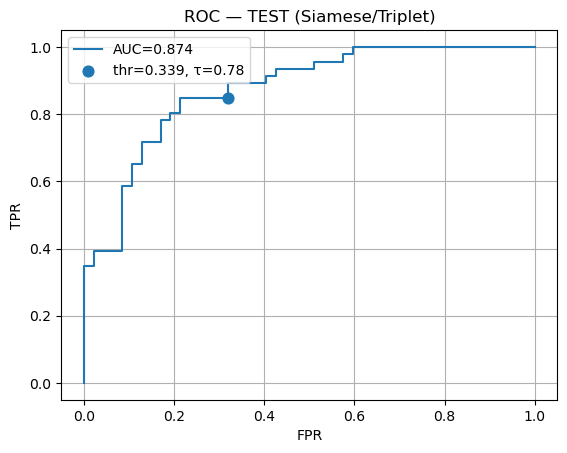

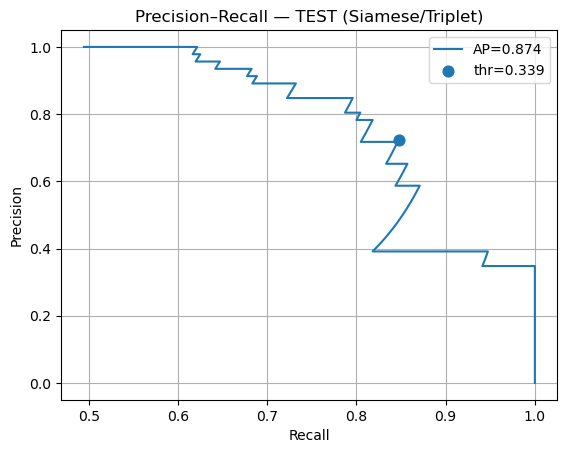

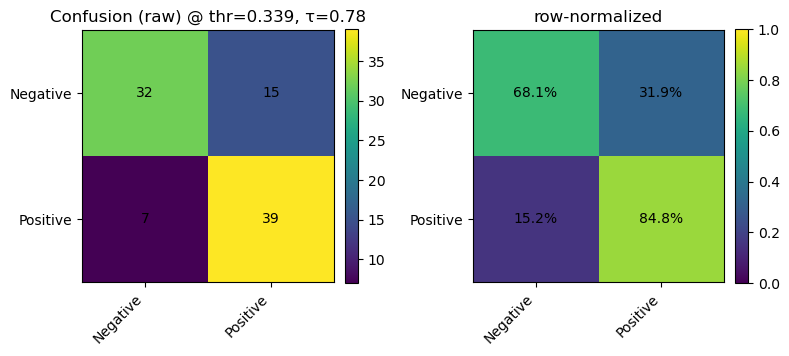

In [13]:
def plot_all(tag, probs, targets, thr, tau_used):
    auc = roc_auc_score(targets, probs) if len(np.unique(targets))>1 else float("nan")
    ap  = average_precision_score(targets, probs)
    preds = (probs>=thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    tpr_point = tp/(tp+fn) if (tp+fn)>0 else 0.0
    fpr_point = fp/(fp+tn) if (fp+tn)>0 else 0.0
    prec_point= tp/(tp+fp) if (tp+fp)>0 else 0.0

    # ROC
    if not np.isnan(auc):
        fpr, tpr, _ = roc_curve(targets, probs)
        plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.scatter([fpr_point],[tpr_point], s=60, label=f"thr={thr:.3f}, τ={tau_used:.2f}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {tag}")
        plt.grid(True); plt.legend(); plt.show()

    # PR
    rec, prec, _ = precision_recall_curve(targets, probs)
    plt.figure(); plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.scatter([tpr_point],[prec_point], s=60, label=f"thr={thr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall — {tag}")
    plt.grid(True); plt.legend(); plt.show()

    # Matrices
    cm = confusion_matrix(targets, preds, labels=[0,1])
    cm_norm = cm.astype(float)/cm.sum(axis=1, keepdims=True).clip(min=1)
    fig, axes = plt.subplots(1,2, figsize=(8,3.8))
    ax=axes[0]; im=ax.imshow(cm); ax.set_title(f"Confusion (raw) @ thr={thr:.3f}, τ={tau_used:.2f}")
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): ax.text(j,i,int(cm[i,j]),ha="center",va="center")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax=axes[1]; im2=ax.imshow(cm_norm, vmin=0, vmax=1); ax.set_title("row-normalized")
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]): ax.text(j,i,f"{cm_norm[i,j]*100:.1f}%",ha="center",va="center")
    plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# Visualiza con umbral máx-F1
plot_all("TEST (Siamese/Triplet)", pt, yt, opt_f1["thr"], tau_val)